In [1]:
import json
import time

import numpy as np
import seaborn as sn

from classify import classify

np.random.seed(0)

questions = open('tossups.json').readlines() + open('bonuses.json').readlines()
np.random.shuffle(questions)
questions = questions[:int(0.2*len(questions))]
print('Number of questions in test set:', len(questions))

with open('subcategories.txt') as f:
    SUBCATEGORIES = [line.strip() for line in f.readlines()]

Number of questions in test set: 60396


In [3]:
EPSILON = 0.01

print('=====Begin Testing=====')
time_now = time.perf_counter()

counter = 0
correct = 0
confusion_matrix = [[0 for _ in range(len(SUBCATEGORIES))] for _ in range(len(SUBCATEGORIES))]

for line in questions:
    data = json.loads(line)
    data["type"] = "tossup" if "question" in data else "bonus"

    if 'subcategory' not in data:
        continue

    subcategory = data['subcategory']

    if subcategory not in SUBCATEGORIES:
        continue

    counter += 1

    if data['type'] == 'tossup':
        prediction = classify(data['question_sanitized'] + ' ' + data['answer_sanitized'], EPSILON=EPSILON)

    if data['type'] == 'bonus' and 'parts_sanitized' in data and len(data['parts_sanitized']) == 3:
        prediction = classify(data['leadin_sanitized'] + ' ' + ' '.join(data['parts_sanitized']) + ' ' + ' '.join(data['answers_sanitized']), EPSILON=EPSILON)

    subcategory_index = SUBCATEGORIES.index(subcategory)
    prediction_index = SUBCATEGORIES.index(prediction)

    confusion_matrix[subcategory_index][prediction_index] += 1

    if subcategory == prediction:
        correct += 1

    if counter % 10000 == 0:
        print(f'{correct}/{counter}')

print('=====End Testing=====')
print(f'Accuracy: {100 * correct / counter}% ({correct}/{counter})')
print(f'Time: {time.perf_counter() - time_now} seconds')

=====Begin Testing=====
8644/10000
17301/20000
25934/30000
34590/40000
43179/50000
=====End Testing=====
Accuracy: 86.34988613575338% (50810/58842)
Time: 16.328999458 seconds


In [4]:
for i, subcat in enumerate(SUBCATEGORIES):
    accuracy = 0.0 if sum(confusion_matrix[i]) == 0 else confusion_matrix[i][i] / sum(confusion_matrix[i])
    accuracy = round(100 * accuracy, 2)
    print(f'{subcat + ":":21} {str(confusion_matrix[i][i]) + "/" + str(sum(confusion_matrix[i])):10} ({accuracy}%)')

American Literature:  3268/3905  (83.69%)
British Literature:   2731/3146  (86.81%)
European Literature:  2324/2603  (89.28%)
World Literature:     1689/2009  (84.07%)
American History:     3249/3843  (84.54%)
Ancient History:      780/914    (85.34%)
European History:     3686/4508  (81.77%)
World History:        2779/3446  (80.64%)
Biology:              2759/3011  (91.63%)
Chemistry:            2329/2611  (89.2%)
Physics:              2817/3099  (90.9%)
Other Science:        2623/3030  (86.57%)
Visual Fine Arts:     3088/3429  (90.06%)
Auditory Fine Arts:   2802/3255  (86.08%)
Other Fine Arts:      1291/1790  (72.12%)
Religion:             2179/2402  (90.72%)
Mythology:            2541/2765  (91.9%)
Philosophy:           2116/2306  (91.76%)
Social Science:       1951/2213  (88.16%)
Current Events:       529/698    (75.79%)
Geography:            1479/1785  (82.86%)
Trash:                1800/2074  (86.79%)


In [5]:
print('Confusion Matrix:')
for subcat, row in zip(SUBCATEGORIES, confusion_matrix):
    print(f'{subcat:20}', row)

Confusion Matrix:
American Literature  [3268, 117, 114, 142, 28, 4, 10, 2, 2, 2, 3, 6, 9, 5, 23, 6, 11, 22, 15, 5, 4, 107]
British Literature   [130, 2731, 79, 54, 9, 5, 18, 4, 4, 2, 3, 5, 8, 5, 8, 6, 14, 19, 7, 4, 4, 27]
European Literature  [59, 71, 2324, 47, 3, 3, 12, 3, 2, 1, 3, 0, 3, 3, 16, 6, 20, 12, 7, 0, 1, 7]
World Literature     [82, 70, 73, 1689, 2, 3, 2, 3, 1, 3, 2, 1, 4, 1, 16, 5, 19, 9, 6, 1, 3, 14]
American History     [34, 6, 5, 2, 3249, 7, 68, 85, 4, 5, 2, 13, 9, 4, 13, 16, 6, 10, 40, 135, 65, 65]
Ancient History      [1, 3, 1, 0, 5, 780, 44, 41, 1, 1, 0, 2, 3, 2, 1, 8, 8, 2, 1, 2, 8, 0]
European History     [8, 22, 15, 8, 93, 183, 3686, 143, 0, 0, 3, 4, 17, 4, 27, 35, 10, 33, 35, 86, 74, 22]
World History        [10, 9, 5, 17, 75, 113, 139, 2779, 3, 0, 2, 6, 3, 5, 18, 18, 5, 7, 7, 111, 104, 10]
Biology              [7, 5, 1, 1, 12, 3, 5, 6, 2759, 61, 19, 36, 3, 1, 5, 2, 3, 6, 35, 7, 23, 11]
Chemistry            [1, 3, 2, 0, 6, 2, 3, 1, 53, 2329, 162, 21, 1, 1, 2, 0, 2

<Axes: >

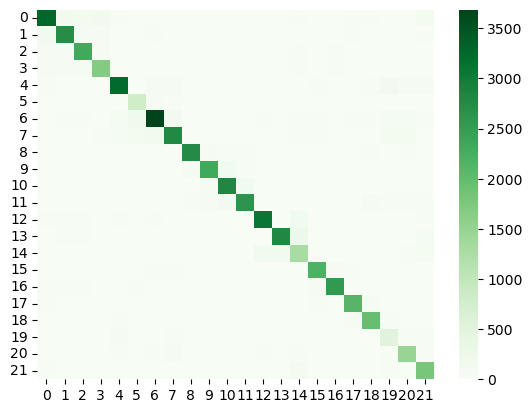

In [6]:
sn.heatmap(confusion_matrix, cmap='Greens', annot=False)

<Axes: >

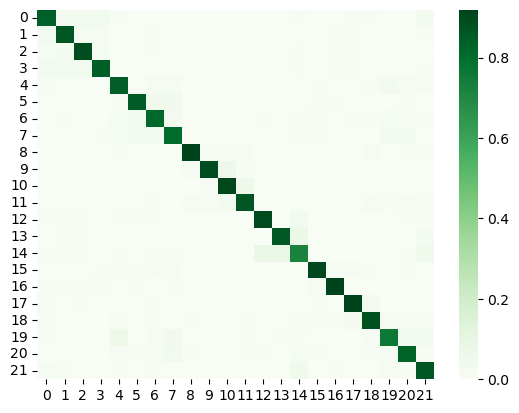

In [7]:
# use relative proportions instead of absolute values
sn.heatmap([[confusion_matrix[i][j] / sum(confusion_matrix[i]) for j in range(len(confusion_matrix[i]))] for i in range(len(confusion_matrix))], cmap='Greens', annot=False)